# Example usage of py-wsi

If you find any bugs or issues, please submit an issue on the [py-wsi Github issue page](https://github.com/ysbecca/py-wsi/issues), providing as much information about the error as possible. Feel free to post usage questions there as well. Thank you!

Author: @ysbecca

Outline
------------------------------------------------------------------------------------------
This notebook covers the following examples, to show how to use py-wsi:

1. Setting parameters
2. **LMDB - storage_type="lmdb"**
    1. introduction to the turtle manager
    2. retrieving tile dimensions
    3. getting sample patches
    4. sample_and_store_patches() function
    5. loading patches (same for all storage types)
        - from one specific whole-slide image
        - by default sets (the ith set contains patches from every ith whole-slide image)
        - using custom sets
3. **Disk - storage_type="disk"**
    1. sample_and_store_patches() function
    2. PNG naming convention
4. **HDF5 - storage_type="hdf5"**
6. A simple Dataset class



More information on py-wsi usage is available on my blog: [Rebecca Stone Blog](ysbecca.github.io)

In [1]:
import py_wsi
import py_wsi.imagepy_toolkit as tk

/Users/ysbecca/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. Parameters

Set parameters for file directory of SVS images, patch size, level (magnification), and overlap.

In [2]:
file_dir = "/Users/ysbecca/ysbecca-projects/py_wsi/py_wsi/wsi_data/"
db_location = "/Users/ysbecca/ysbecca-projects/py_wsi/"
xml_dir = file_dir
patch_size = 64
level = 10
db_name = "patch_db"
overlap = 0

# All possible labels mapped to integer ids in order of increasing severity.
label_map = {'Normal': 0,
             'Benign': 1,
             'Carcinoma in situ': 2,
             'In situ carcinoma': 2,
             'Carcinoma invasive': 3,
             'Invasive carcinoma': 3,
            }

# 2. LMDB

### A. Turtle manager introduction

Create a new py-wsi manager object for our collection of svs images. It's called a turtle. We will use the storage option **LMDB** (which is also set by default, for backwards compatibility.)

In [3]:
turtle = py_wsi.Turtle(file_dir, db_location, db_name, xml_dir=xml_dir, label_map=label_map, storage_type='lmdb')

Storage type:               lmdb
Images directory:           /Users/ysbecca/ysbecca-projects/py_wsi/py_wsi/wsi_data/
Data store directory:       /Users/ysbecca/ysbecca-projects/py_wsi/
Images found:               10


The Turtle object keeps track of how many WSI images are in its collection, and the LMDB that stores the patches and their info.

In [4]:
print("Total WSI images:    " + str(turtle.num_files))
print("LMDB name:           " + str(turtle.db_name))
print("File names:          " + str(turtle.files))
print("XML files found:     " + str(turtle.get_xml_files()))

Total WSI images:    10
LMDB name:           patch_db
File names:          ['A01.svs' 'A02.svs' 'A03.svs' 'A04.svs' 'A05.svs' 'A06.svs' 'A07.svs'
 'A08.svs' 'A09.svs' 'A10.svs']
XML files found:     ['A01.xml' 'A02.xml' 'A03.xml' 'A04.xml' 'A05.xml' 'A06.xml' 'A07.xml'
 'A08.xml' 'A09.xml' 'A10.xml']


### B. Retrieving tile dimensions and levels

The Turtle manager allows you to explore the dimensions and tile levels of your images.

```python
def retrieve_tile_dimensions(file_name, patch_size=0, overlap=0, tile_size=0):
    # Locates the file and retrieves tile information.
    return level_count, level_tiles, level_dims
```


In [5]:
level_count, level_tiles, level_dims = turtle.retrieve_tile_dimensions('A01.svs', patch_size=128)
print("Level count:         " + str(level_count))
print("Level tiles:         " + str(level_tiles))
print("Level dimensions:    " + str(level_dims))

Setting patch size 128 and tile size 128
Level count:         17
Level tiles:         ((1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 2), (4, 3), (8, 6), (16, 11), (31, 21), (62, 42), (123, 83), (245, 165), (490, 330))
Level dimensions:    ((1, 1), (2, 2), (4, 3), (8, 6), (16, 11), (31, 21), (62, 42), (123, 83), (245, 165), (490, 330), (979, 659), (1958, 1317), (3915, 2633), (7829, 5265), (15657, 10529), (31313, 21057), (62625, 42113))


### C. Getting sample patches

The Turtle manager can also return a sample patch.

```python
def retrieve_sample_patch(file_name, patch_size, level, overlap=0):
    # Fetches a sample patch from the centre of the image.
    return patch
```

In [6]:
patch_1 = turtle.retrieve_sample_patch("A01.svs", 256, 12, overlap=12)
patch_2 = turtle.retrieve_sample_patch("A01.svs", 128, 12, overlap=12)
patch_3 = turtle.retrieve_sample_patch("A01.svs", 64, 12, overlap=12)

The imagepy_toolkit included in py_wsi allows for quick displaying of patches.

```python
def show_images(array_of_patches, patches_per_row, patches_per_col)
```

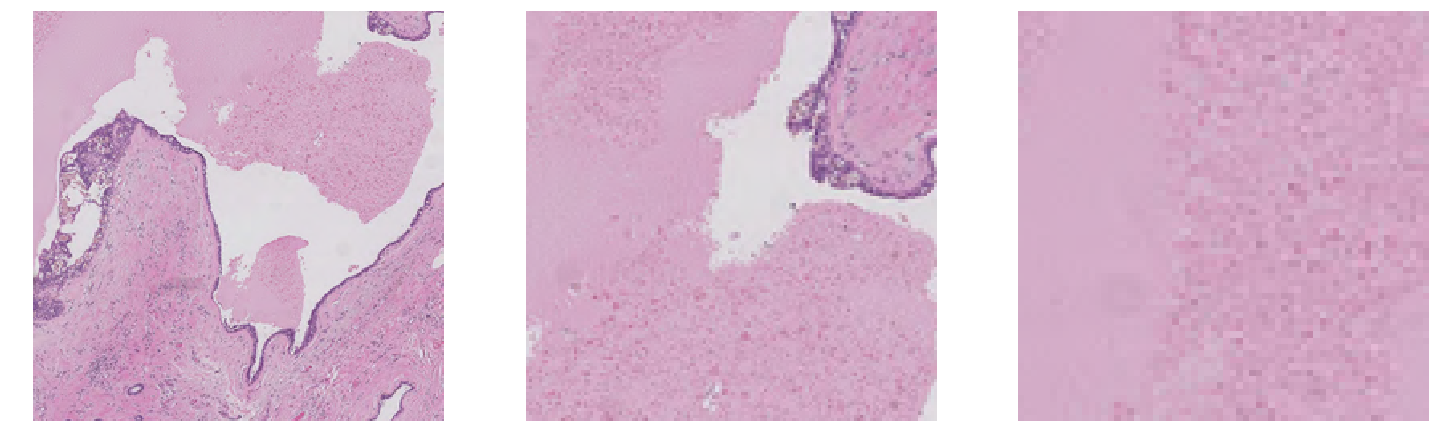

In [7]:
tk.show_images([patch_1, patch_2, patch_3], 3, 1)

### D. sample_and_store_patches() function

Once you have decided what patch size and level you need, you can sample patches and store them in a new LMDB database. This actually creates two databases, one for the patches themselves and another for the image metadata, specifically, the tile dimensions. The second database is only used internally, for retrieving patches from the first database.

**load_xml=True** looks for XML files in the XML directory and labels patches according to any regions provided 
in the XML files. If there are any region names found in the XML files which do not match keys in the label_map, an error message will show and the patches will be given the default label of -1.

In [8]:
print("Patch size:", patch_size)
turtle.sample_and_store_patches(patch_size, level, overlap, load_xml=True, limit_bounds=True)

Patch size: 64
Pre-calculated map sizes:
 - patch db:     532955136 bytes
 - meta db:      396544 bytes
Creating new LMDB environment...
A01.svs A02.svs A03.svs A04.svs A05.svs A06.svs A07.svs A08.svs A09.svs A10.svs 
====== LMDB patch_db Stats ======
{'psize': 4096, 'depth': 2, 'branch_pages': 1, 'leaf_pages': 16, 'overflow_pages': 5224, 'entries': 1306}
====== LMDB patch_db_meta Stats ======
{'psize': 4096, 'depth': 1, 'branch_pages': 0, 'leaf_pages': 1, 'overflow_pages': 0, 'entries': 10}
Time usage: 0:00:20


### E. loading patches (same for all storage types)

Now you can load the patches and associated meta data from the database using the Turtle manager. The Turtle supports several ways of retrieving patches.

**(1) From one specific image at a time:**

In [9]:
patches, coords, classes, labels = turtle.get_patches_from_file("A01.svs")

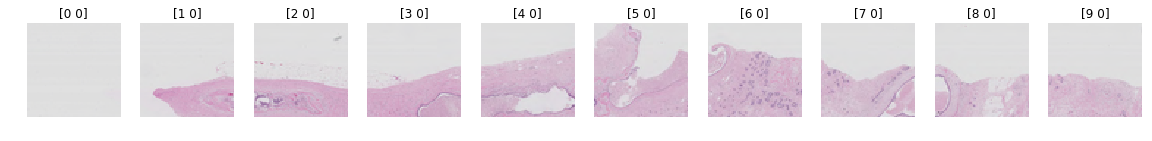

In [10]:
tk.show_labeled_patches(patches[:10], coords[:10])

**(2) By sets (assuming training with batches as is often the case with large datasets). The sets are computed very simply where the ith image in the directory belongs to the ith set. **

In [11]:
set_id = 0
total_sets = 2
patches, coords, classes, labels = turtle.get_set_patches(set_id, total_sets)

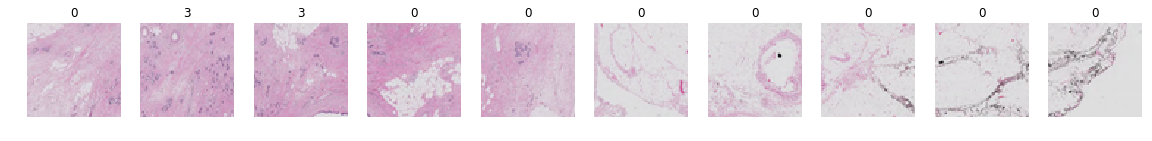

In [12]:
tk.show_labeled_patches(patches[50:60], classes[50:60])

**(3) Alternatively, you can specify your own set by passing a binary selection array, where from all non-zero indices i will result in all patches from the ith image in the directory being loaded.**

```python
def get_set_patches(self, set_id, total_sets, select=[]):
    # The default: ith image in directory belonging to the ith set
    select = np.zeros(self.num_files)
    select[set_id:self.num_files:total_sets] = 1
```

An example of passing in a custom select array:

In [13]:
custom_set_select = [0, 0, 0, 1, 1, 1, 0, 0, 0, 1]
total_sets = 2
set_id = 1

patches, coords, classes, labels = turtle.get_set_patches(set_id, total_sets, select=custom_set_select)

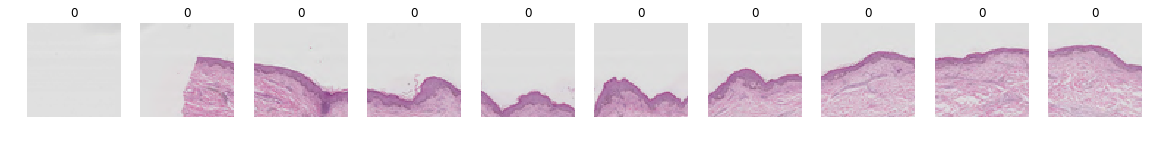

In [14]:
tk.show_labeled_patches(patches[:10], classes[:10])

# 3. Disk


Alternately, you may want to save your patches to disk as PNG files. Let's create a new turtle manager using **storage_type='disk'**.

In [15]:
turtle = py_wsi.Turtle(file_dir, db_location, db_name, xml_dir=xml_dir, label_map=label_map, storage_type='disk')

Storage type:               disk
Images directory:           /Users/ysbecca/ysbecca-projects/py_wsi/py_wsi/wsi_data/
Data store directory:       /Users/ysbecca/ysbecca-projects/py_wsi/
Images found:               10


### A. sample_and_store_patches() function

Now we can use the sample and store function again:

In [16]:
turtle.sample_and_store_patches(patch_size, level, overlap, load_xml=True, limit_bounds=True)

A01.svs A02.svs A03.svs A04.svs A05.svs A06.svs A07.svs A08.svs A09.svs A10.svs 
============ Patches Dataset Stats ===========
Total patches sampled:                     1306
Patches saved to:                          /Users/ysbecca/ysbecca-projects/py_wsi/
Patches saved with prefix:                 patch_db

Time usage: 0:00:24


We can load the patches using the exact same functions as shown earlier for LMDB.

In [17]:
patches, coords, classes, labels = turtle.get_patches_from_file("A02.svs", verbose=True)

[py-wsi] loaded 143 patches from A02


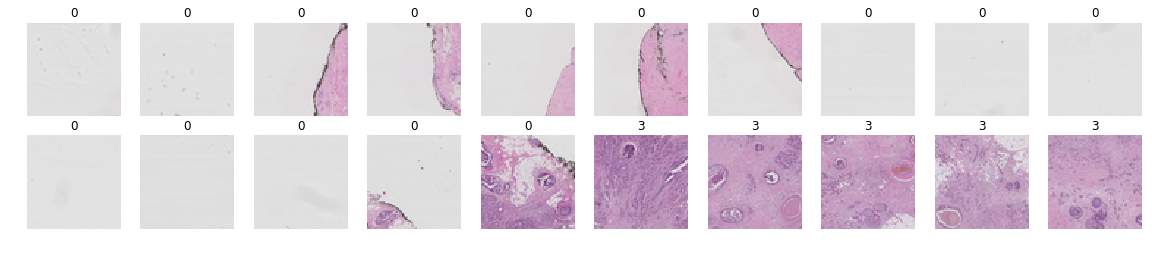

In [18]:
tk.show_labeled_patches(patches[:20], classes[:20])

### B. PNG naming convention

You should find all the patches saved as PNG files in the given directory. The naming format is as follows:

```python
[WSI_file_name]_[x_tile_coord]_[y_tile_coord]_[label].png
```

If you have not provided XML annotation files, then the label will be lacking. Feel free to rename the files, but be aware that you will need to reflect the change in the code which loads the patches, as it will expect this format.

# 4. HDF5

The third option supported by py-wsi is to save the sampled patches to HDF5 files. You can read more about HDF5 [here](https://en.wikipedia.org/wiki/Hierarchical_Data_Format), or on [my blog](https://ysbecca.github.io). We will re-create the turtle manager, with this option.

In [19]:
turtle = py_wsi.Turtle(file_dir, db_location, db_name, xml_dir=xml_dir, label_map=label_map, storage_type='hdf5')

Storage type:               hdf5
Images directory:           /Users/ysbecca/ysbecca-projects/py_wsi/py_wsi/wsi_data/
Data store directory:       /Users/ysbecca/ysbecca-projects/py_wsi/
Images found:               10


Now we will sample again.

In [20]:
turtle.sample_and_store_patches(patch_size, level, overlap, load_xml=True, limit_bounds=True)

A01.svs A02.svs A03.svs A04.svs A05.svs A06.svs A07.svs A08.svs A09.svs A10.svs Time usage: 0:00:20


In the data store directory, you will find that an .h5 and .csv file have been created for each whole-slide image. These contain the numpy arrays of all the patches.

In [21]:
patches, coords, classes, labels = turtle.get_patches_from_file("A02.svs", verbose=True)

[py-wsi] loaded from A02 .h5 file (143, 64, 64, 3)


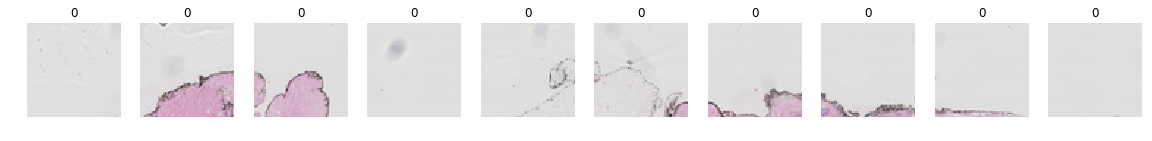

In [22]:
tk.show_labeled_patches(patches[:10], classes[:10])

## 5. A simple Dataset class

A simple Dataset class is also included, adapted from the [Hvass-Labs tutorials](https://github.com/Hvass-Labs/TensorFlow-Tutorials). This Dataset class works the same regardless of your storage type.

In [23]:
import py_wsi.dataset as ds

In [24]:
dataset = ds.read_datasets(turtle,
                set_id=1,
                valid_id=0,
                total_sets=2,
                shuffle_all=True,
                augment=True)

We can see the dataset information read in from the LMDB:

In [25]:
print("Total training set patches:     " + str(len(dataset.train.images)))
print("Total validation set patches:   " + str(len(dataset.valid.images)))

Total training set patches:     6246
Total validation set patches:   5508


And can view some of the original patches:

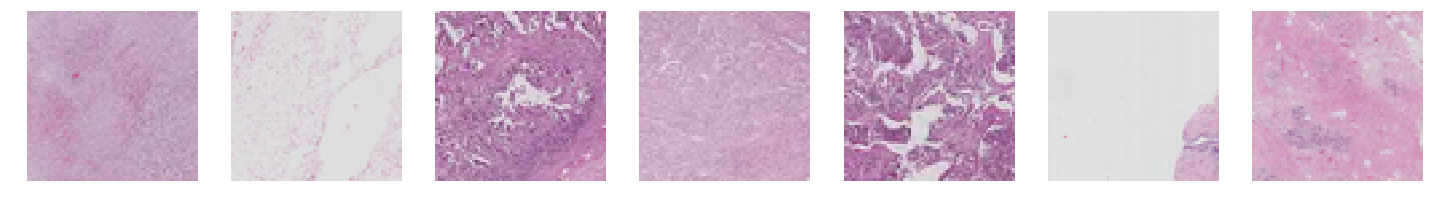

In [26]:
tk.show_images(dataset.train.images, 7, 1)

We can also view the labels associated with these patches.

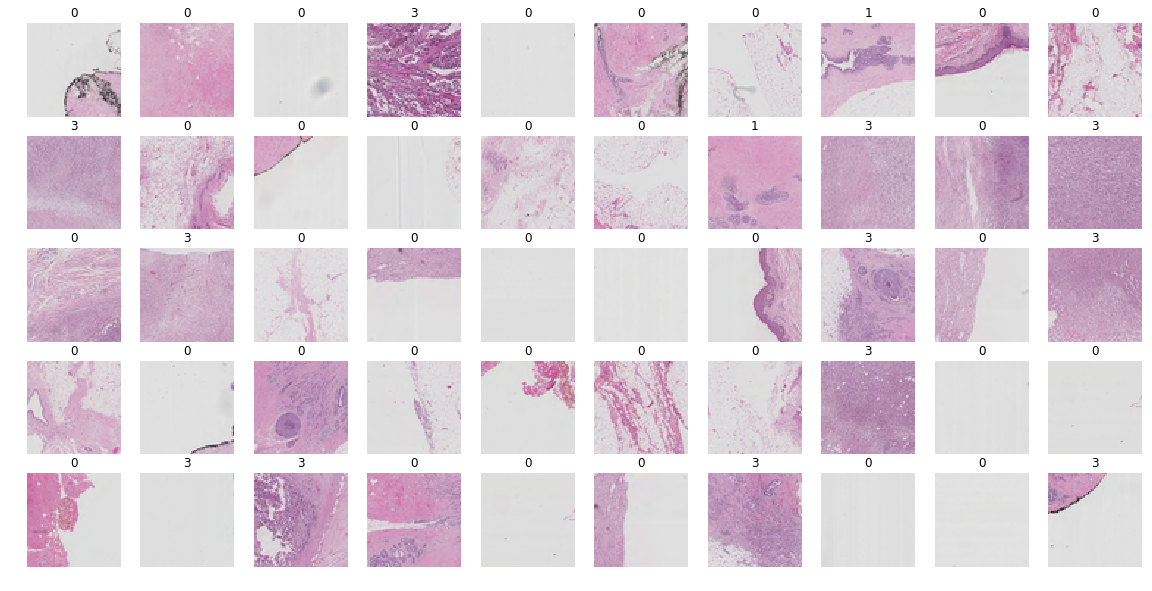

In [9]:
tk.show_labeled_patches(dataset.train.images, dataset.train.image_cls)

The Dataset class supports reading by batches, epoch counting, etc. See the code to see how to use. It is a very basic model and is meant to be customised based on the dataset.

Again, if you find any bugs or issues, please submit an issue on the [py-wsi Github issue page](https://github.com/ysbecca/py-wsi/issues), providing as much information about the error as possible. Feel free to post usage questions there as well. Thank you!